In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import numpy as np
import re
import copy
from typing import List, Tuple, Dict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import polars as pl


import sys
sys.path.append('../')
from utils import *

In [2]:
is_kaggle = False

if is_kaggle:
    base_dir = '/kaggle/input'
    data_dir = f'{base_dir}/linking-writing-processes-to-writing-quality'
    output_dir = '/kaggle/working'
else:
    base_dir = '../'
    data_dir = f'{base_dir}/data'
    models_dir = f'{base_dir}/models'

In [3]:
train_logs = pl.scan_csv('../kaggle feat_eng/train_logs_double_corrected.csv')

In [4]:
output_name = 'train_double_corr_786feats.csv'

In [5]:
# train_logs_df = pd.read_csv(f'../kaggle feat_eng/train_logs_corrected.csv')
# train_scores_df = pd.read_csv(f'{data_dir}/train_scores.csv')

# test_logs_df = pd.read_csv(f'../kaggle feat_eng/test_logs_corrected.csv')

In [6]:
def append_features(train_feats, temp_feats, suffix):
    for col in temp_feats.columns:
        if col != 'id':
            temp_feats = temp_feats.rename(columns={col: col + suffix})
    train_feats = train_feats.merge(temp_feats, on='id', how='left')
    return train_feats

# Feats

## Features related to counts and bursts

In [7]:
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete'] #, 'Unidentified', 'Clear', 'PageUp', 'PageDown']
text_changes = ['q', ' ', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']


def count_by_values(df, colname, values):
    fts = df.select(pl.col('id').unique(maintain_order=True))
    for i, value in enumerate(values):
        tmp_df = df.group_by('id').agg(pl.col(colname).is_in([value]).sum().alias(f'{colname}_{i}_cnt'))
        fts  = fts.join(tmp_df, on='id', how='left')
    return fts


def dev_feats(df):
    
    print("< Count by values features >")
    
    feats = count_by_values(df, 'activity', activities)
    feats = feats.join(count_by_values(df, 'text_change', text_changes), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'down_event', events), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'up_event', events), on='id', how='left') 

    print("< Input words stats features >")

    temp = df.filter((~pl.col('text_change').str.contains('=>')) & (pl.col('text_change') != 'NoChange'))
    temp = temp.group_by('id').agg(pl.col('text_change').str.concat('').str.extract_all(r'q+'))
    temp = temp.with_columns(input_word_count = pl.col('text_change').list.len(),
                             input_word_length_mean = pl.col('text_change').map_elements(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_max = pl.col('text_change').map_elements(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_std = pl.col('text_change').map_elements(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_median = pl.col('text_change').map_elements(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_skew = pl.col('text_change').map_elements(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)))
    temp = temp.drop('text_change')
    feats = feats.join(temp, on='id', how='left') 


    
    print("< Numerical columns features >")

    temp = df.group_by("id").agg(pl.sum('action_time').name.suffix('_sum'), pl.mean(num_cols).name.suffix('_mean'), pl.std(num_cols).name.suffix('_std'),
                                 pl.median(num_cols).name.suffix('_median'), pl.min(num_cols).name.suffix('_min'), pl.max(num_cols).name.suffix('_max'),
                                 pl.quantile(num_cols, 0.5).name.suffix('_quantile'))
    feats = feats.join(temp, on='id', how='left') 


    print("< Categorical columns features >")
    
    temp  = df.group_by("id").agg(pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
    feats = feats.join(temp, on='id', how='left') 


    print("< Idle time features >")

    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.group_by("id").agg(inter_key_largest_lantency = pl.max('time_diff'),
                                   inter_key_median_lantency = pl.median('time_diff'),
                                   mean_pause_time = pl.mean('time_diff'),
                                   std_pause_time = pl.std('time_diff'),
                                   total_pause_time = pl.sum('time_diff'),
                                   pauses_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') < 1)).count(),
                                   pauses_1_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') < 1.5)).count(),
                                   pauses_1_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1.5) & (pl.col('time_diff') < 2)).count(),
                                   pauses_2_sec = pl.col('time_diff').filter((pl.col('time_diff') > 2) & (pl.col('time_diff') < 3)).count(),
                                   pauses_3_sec = pl.col('time_diff').filter(pl.col('time_diff') > 3).count(),)
    feats = feats.join(temp, on='id', how='left') 
    

    print("< P-bursts features >")

    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('time_diff')<2)
    temp = temp.with_columns(pl.when(pl.col("time_diff") & pl.col("time_diff").is_last_distinct()).then(pl.count()).over(pl.col("time_diff").rle_id()).alias('P-bursts'))
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(pl.mean('P-bursts').name.suffix('_mean'), pl.std('P-bursts').name.suffix('_std'), pl.count('P-bursts').name.suffix('_count'),
                                   pl.median('P-bursts').name.suffix('_median'), pl.max('P-bursts').name.suffix('_max'),
                                   pl.first('P-bursts').name.suffix('_first'), pl.last('P-bursts').name.suffix('_last'))
    feats = feats.join(temp, on='id', how='left') 


    print("< R-bursts features >")

    temp = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('activity').is_in(['Remove/Cut']))
    temp = temp.with_columns(pl.when(pl.col("activity") & pl.col("activity").is_last_distinct()).then(pl.count()).over(pl.col("activity").rle_id()).alias('R-bursts'))
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(pl.mean('R-bursts').name.suffix('_mean'), pl.std('R-bursts').name.suffix('_std'), 
                                   pl.median('R-bursts').name.suffix('_median'), pl.max('R-bursts').name.suffix('_max'),
                                   pl.first('R-bursts').name.suffix('_first'), pl.last('R-bursts').name.suffix('_last'))
    feats = feats.join(temp, on='id', how='left')
    
    return feats

In [8]:
train_feats   = dev_feats(train_logs)
train_feats   = train_feats.collect().to_pandas()
for col in train_feats.columns:
    if col != 'id':
        train_feats = train_feats.rename(columns={col: col + '-count_bursts'})
len(train_feats.columns)

< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >


114

## Reconstruct essays

In [9]:
def reconstruct_essay(currTextInput):
    essayText = ""
    for Input in currTextInput.values:
        if Input[0] == 'Replace':
            replaceTxt = Input[2].split(' => ')
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue
        if Input[0] == 'Paste':
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue
        if Input[0] == 'Remove/Cut':
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue
        if "M" in Input[0]:
            croppedTxt = Input[0][10:]
            splitTxt = croppedTxt.split(' To ')
            valueArr = [item.split(', ') for item in splitTxt]
            moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
            if moveData[0] != moveData[2]:
                if moveData[0] < moveData[2]:
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                else:
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
    return essayText


def get_essay_df(df):
    df       = df[df.activity != 'Nonproduction']
    temp     = df.groupby('id').apply(lambda x: reconstruct_essay(x[['activity', 'cursor_position', 'text_change']]))
    essay_df = pd.DataFrame({'id': df['id'].unique().tolist()})
    essay_df = essay_df.merge(temp.rename('essay'), on='id')
    return essay_df

In [10]:
train_logs = train_logs.collect().to_pandas()

print('< Essay Reconstruction >')
train_essays = get_essay_df(train_logs)

< Essay Reconstruction >


In [11]:
train_essays.head()

,id,essay
0,001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
1,0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
2,0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
3,0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
4,0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."


## Idle time

In [12]:
temp_feats = train_logs.groupby('id')['idle_time'].apply(lambda x: x.unique()[0]).reset_index()
train_feats = append_features(train_feats, temp_feats, suffix='-idle')

## Aggregations at word/sentence/paragraph/essay level

In [13]:
def q0(x):
    return x.quantile(0.10)
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)
def q4(x):
    return x.quantile(0.90)

AGGREGATIONS = ['count', 'mean', 'min', 'max', 'first', 'last', q1, 'median', q3, 'sum'] #, q0, q4, 'sem', 'std', 'var', 'skew', pd.DataFrame.kurt]

def word_feats(df):
    df['word'] = df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!',x))
    df = df.explode('word')
    df['word_len'] = df['word'].apply(lambda x: len(x))
    df = df[df['word_len'] != 0]

    word_agg_df = df[['id','word_len']].groupby(['id']).agg(AGGREGATIONS)
    word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
    word_agg_df['id'] = word_agg_df.index
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df


def sent_feats(df):
    df['sent'] = df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    df = df.explode('sent')
    df['sent'] = df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    df['sent_len'] = df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    df['sent_word_count'] = df['sent'].apply(lambda x: len(x.split(' ')))
    df = df[df.sent_len!=0].reset_index(drop=True)

    sent_agg_df = pd.concat([df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), 
                             df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1)
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df


def parag_feats(df):
    df['paragraph'] = df['essay'].apply(lambda x: x.split('\n'))
    df = df.explode('paragraph')
    # Number of characters in paragraphs
    df['paragraph_len'] = df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    df['paragraph_word_count'] = df['paragraph'].apply(lambda x: len(x.split(' ')))
    df = df[df.paragraph_len!=0].reset_index(drop=True)
    
    paragraph_agg_df = pd.concat([df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), 
                                  df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

def essay_feats(df):
    # Number of characters in paragraphs
    df['essay_len'] = df['essay'].apply(lambda x: len(x))
    # Number of words in paragraphs
    df['essay_word_count'] = df['essay'].apply(lambda x: len(x.split(' ')))
    return df[['id','essay_len','essay_word_count']]

def product_to_keys(logs, essays):
    essays['product_len'] = essays.essay.str.len()
    tmp_df = logs[logs.activity.isin(['Input', 'Remove/Cut'])].groupby(['id']).agg({'activity': 'count'}).reset_index().rename(columns={'activity': 'keys_pressed'})
    essays = essays.merge(tmp_df, on='id', how='left')
    essays['product_to_keys'] = essays['product_len'] / essays['keys_pressed']
    return essays[['id', 'product_to_keys']]

def get_keys_pressed_per_second(logs):
    temp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg(keys_pressed=('event_id', 'count')).reset_index()
    temp_df_2 = logs.groupby(['id']).agg(min_down_time=('down_time', 'min'), max_up_time=('up_time', 'max')).reset_index()
    temp_df = temp_df.merge(temp_df_2, on='id', how='left')
    temp_df['keys_per_second'] = temp_df['keys_pressed'] / ((temp_df['max_up_time'] - temp_df['min_down_time']) / 1000)
    return temp_df[['id', 'keys_per_second']]

In [14]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(word_feats(train_essays), on='id', how='left')
temp_feats = temp_feats.merge(sent_feats(train_essays), on='id', how='left')
temp_feats = temp_feats.merge(parag_feats(train_essays), on='id', how='left')
temp_feats = temp_feats.merge(essay_feats(train_essays), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-word_sent_parag_agg')
print(len(train_feats.columns))

165


In [15]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(get_keys_pressed_per_second(train_logs), on='id', how='left')
temp_feats = temp_feats.merge(product_to_keys(train_logs, train_essays), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-pressed_keys')
print(len(train_feats.columns))

167


## Count pauses

In [16]:
def count_pauses_2s(group):
    """Counts pauses longer than 2000 ms."""
    gap = group['down_time'] - group['up_time'].shift(1)
    return (gap > 2000).sum()

def count_pauses_5s(group):
    """Counts pauses longer than 2000 ms."""
    gap = group['down_time'] - group['up_time'].shift(1)
    return (gap > 5000).sum()

def pause_proportion_2s(group):
    """Calculates the proportion of pause time to total essay time."""
    gap = group['down_time'] - group['up_time'].shift(1)
    total_pause_time = gap[gap > 2000].sum()
    total_essay_time = group['up_time'].max() - group['down_time'].min()
    return total_pause_time / total_essay_time if total_essay_time else 0

def pause_proportion_5s(group):
    """Calculates the proportion of pause time to total essay time."""
    gap = group['down_time'] - group['up_time'].shift(1)
    total_pause_time = gap[gap > 2000].sum()
    total_essay_time = group['up_time'].max() - group['down_time'].min()
    return total_pause_time / total_essay_time if total_essay_time else 0

def mean_pause_length(group):
    """Calculates the mean length of pauses longer than 2000 ms."""
    gap = group['down_time'] - group['up_time'].shift(1)
    pauses = gap[gap > 2000]
    return pauses.mean() / 1000 if not pauses.empty else 0

def median_pause_length(group):
    """Calculates the mean length of pauses longer than 2000 ms."""
    gap = group['down_time'] - group['up_time'].shift(1)
    pauses = gap[gap > 2000]
    return pauses.median() / 1000 if not pauses.empty else 0

# Method to aggregate all pause-related features
def aggregate_pause_features(df):
    """Aggregates all pause-related features for each essay."""
    grouped = df.groupby('id')
    pause_features = pd.DataFrame()
    pause_features['n_pauses_2s'] = grouped.apply(count_pauses_2s)
    pause_features['n_pauses_5s'] = grouped.apply(count_pauses_5s)
    pause_features['pause_proportion_2s'] = grouped.apply(pause_proportion_2s)
    pause_features['pause_proportion_5s'] = grouped.apply(pause_proportion_5s)
    pause_features['mean_pause_length'] = grouped.apply(mean_pause_length)
    pause_features['median_pause_length'] = grouped.apply(median_pause_length)
    return pause_features

def process_variance(group):
    """Calculates the variance in the writing process over time for each essay."""
    if len(group) < 2:  # Handling for groups with a single row
        return 0

    bins = np.linspace(group['down_time'].min(), group['up_time'].max(), 11)
    divisions = pd.cut(group['down_time'], bins=bins, include_lowest=True, labels=range(1, 11))
    production_deciles = group.groupby(divisions).agg(n_events=('event_id', 'count'))
    return np.std(production_deciles['n_events'], ddof=1)

def aggregate_process_variance(df):
    """Aggregates the process variance feature for each essay."""
    return df.groupby('id').apply(process_variance).rename('process_variance').to_frame()

In [17]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(aggregate_pause_features(train_logs).reset_index(), on='id', how='left')
temp_feats = temp_feats.merge(aggregate_process_variance(train_logs).reset_index(), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-paussed_features')
print(len(train_feats.columns))

174


## Calculate cursor visits to different segments

In [18]:
'''
Needs polars dataset
'''

# print("< Cursor moving animation >")

# # Adding 'pos' and 'line' columns
# df = df.with_columns([
#     (pl.col('cursor_position') % 30).alias('pos'),
#     (pl.col('cursor_position') / 30).cast(pl.Int32).alias('line')
# ])

# # Adding 'dist_moved' column
# df = df.with_columns(
#     [pl.col('cursor_position').diff().over('id').fill_null(0).abs().alias('dist_moved')]
# )

# # Calculating average distance moved per event
# avg_dist_per_event = df.groupby('id').agg(
#     pl.mean('dist_moved').alias('avg_dist_per_event')
# )

# # Joining with the feature set
# feats = feats.join(avg_dist_per_event, on='id', how='left')

# # Adding 'line_change' column
# df = df.with_columns(
#     [pl.col('line').diff().over('id').fill_null(0).ne(0).alias('line_change')]
# )

# # Calculating revisits per line and first line revisits
# revisits_per_line = df.filter(pl.col('line_change') == False).group_by(['id', 'line']).agg(
#     pl.count().alias('revisit_count')
# )
# first_line_revisits = revisits_per_line.filter(pl.col('line') == 0).group_by('id').agg(
#     pl.sum('revisit_count').alias('first_line_revisits')
# )

# # Joining with the feature set
# feats = feats.join(first_line_revisits, on='id', how='left')

# # Calculating line changes
# line_changes = df.groupby('id').agg(
#     pl.sum('line_change').alias('line_changes')
# )

# # Joining with the feature set
# feats = feats.join(line_changes, on='id', how='left')

'\nNeeds polars dataset\n'

In [19]:
def calculate_segment_visits(train_logs, train_essays):
    # Calculate the end position of the intro and body for each essay
    train_essays['intro_end'] = train_essays['essay'].apply(lambda x: len(x.split('\n')[0]))
    train_essays['body_end'] = train_essays['essay'].apply(lambda x: len('\n'.join(x.split('\n')[:-1])))

    # Create a dictionary for quick lookup
    ends_dict = train_essays.set_index('id')[['intro_end', 'body_end']].to_dict('index')

    # Function to categorize position
    def categorize_position(row):
        intro_end = ends_dict[row['id']]['intro_end']
        body_end = ends_dict[row['id']]['body_end']
        if row['cursor_position'] <= intro_end:
            return 'intro'
        elif row['cursor_position'] <= body_end:
            return 'body'
        else:
            return 'conclusion'

    # Categorize cursor positions
    train_logs['segment'] = train_logs.apply(categorize_position, axis=1)

    # Count visits to each segment
    segment_visits = train_logs.groupby(['id', 'segment']).size().unstack(fill_value=0)

    # Rename columns for clarity
    segment_visits.columns = [f'{col}_visits' for col in segment_visits.columns]

    return segment_visits

In [20]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(calculate_segment_visits(train_logs, train_essays).reset_index(), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-segments_visit')
print(len(train_feats.columns))

177


In [21]:
scores = pd.read_csv('../data/train_scores.csv')

In [22]:
train_logs[train_logs['id']=='01963e20']

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,idle_time,segment
59875,01963e20,1,0,136,136,Input,q,q,q,1,1,654258,intro
59876,01963e20,2,344,449,105,Input,q,q,q,2,1,654258,intro
59877,01963e20,3,512,665,153,Input,q,q,q,3,1,654258,intro
59878,01963e20,4,608,721,113,Input,q,q,q,4,1,654258,intro
59879,01963e20,5,704,833,129,Input,q,q,q,5,1,654258,intro
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64883,01963e20,5009,1127643,1127736,93,Remove/Cut,Backspace,Backspace,,1654,413,654258,conclusion
64884,01963e20,5010,1128386,1128472,86,Nonproduction,Leftclick,Leftclick,NoChange,1961,413,654258,conclusion
64885,01963e20,5011,1136893,1137582,689,Nonproduction,Leftclick,Leftclick,NoChange,1757,413,654258,conclusion
64886,01963e20,5012,1139574,1139663,89,Nonproduction,Leftclick,Leftclick,NoChange,1758,413,654258,conclusion


## Relative size of paragraphs

In [23]:
def calculate_relative_paragraph_sizes(input_df, essay_column):

    df = input_df.copy()
    # Split the essay text into paragraphs
    df['paragraphs'] = df[essay_column].str.split('\n')

    # Filter out empty paragraphs
    df['paragraphs'] = df['paragraphs'].apply(lambda paragraphs: [p for p in paragraphs if p.strip() != ''])

    # Calculate the total number of paragraphs
    df['total_paragraphs'] = df['paragraphs'].apply(len)

    # Calculate the relative sizes
    df['relative_intro_size'] = 1 / df['total_paragraphs']  # First paragraph is the introduction
    df['relative_body_size'] = (df['total_paragraphs'] - 2) / df['total_paragraphs']  # Middle paragraphs are the body
    df['relative_conclusion_size'] = 1 / df['total_paragraphs']  # Last paragraph is the conclusion

    # Calculate the word count for each paragraph
    df['paragraph_word_count'] = df['paragraphs'].apply(lambda x: [len(paragraph.split()) for paragraph in x])

    # Separate paragraphs into intro, body, and conclusion
    df['word_count_intro'] = df['paragraph_word_count'].apply(lambda x: x[0] if len(x) > 0 else 0)
    df['word_count_body'] = df['paragraph_word_count'].apply(lambda x: sum(x[1:-1]) if len(x) > 2 else 0)
    df['word_count_conclusion'] = df['paragraph_word_count'].apply(lambda x: x[-1] if len(x) > 1 else 0)

    # Calculate total word count for each essay
    df['total_word_count'] = df['paragraph_word_count'].apply(sum)
    
    # Calculate ratios
    df['intro_ratio'] = df['word_count_intro'] / df['total_word_count']
    df['body_ratio'] = df['word_count_body'] / df['total_word_count']
    df['conclusion_ratio'] = df['word_count_conclusion'] / df['total_word_count']
    
    df['intro_body_ratio'] = df['word_count_intro'] / df['word_count_body']
    df['intro_conclusion_ratio'] = df['word_count_intro'] / df['word_count_conclusion']
    df['body_conclusion_ratio'] = df['word_count_body'] / df['word_count_conclusion']

    # Drop intermediate columns if needed
    df.drop(columns=['word', 'sent', 'paragraph', 'paragraphs', 'total_paragraphs', essay_column, 'paragraph_word_count'], inplace=True)

    return df

In [24]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(calculate_relative_paragraph_sizes(train_essays, 'essay').reset_index(), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-paragraph_ratios')
print(len(train_feats.columns))

196


## TF-IDF

In [25]:
# # Customer tokenizer
# def custom_tokenizer(text):
#     words = re.findall(r'\b\w+\b', text.lower())
#     filtered_words = [word for word in words if word.count('q') < 11] # Do not consider words with more than 10 q's
#     return filtered_words

# tfidf_vect = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1,2))

# def make_text_features(self, df, column='text_change', fit_transform=True):
#     """Extracts text features using CountVectorizer and TfidfVectorizer, along with custom features."""
#     # Filter and concatenate text changes
#     filtered_df = df[(~df[column].str.contains('=>')) & (df[column] != 'NoChange')]
#     concatenated_texts = filtered_df.groupby('id')[column].apply(' '.join).reset_index()

#     # Apply CountVectorizer and TfidfVectorizer
#     if fit_transform:
#         bow_features = self.count_vect.fit_transform(concatenated_texts[column])
#         tfidf_features = self.tfidf_vect.fit_transform(concatenated_texts[column])
#     else:
#         bow_features = self.count_vect.transform(concatenated_texts[column])
#         tfidf_features = self.tfidf_vect.transform(concatenated_texts[column])

#     # Convert to DataFrame
#     bow_df = pd.DataFrame(bow_features.toarray(), columns=[f'bow_{name}' for name in self.count_vect.get_feature_names_out()])
#     tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f'tfidf_{name}' for name in self.tfidf_vect.get_feature_names_out()])

#     # Custom Feature: Length of each essay
#     custom_features_df = pd.DataFrame({'custom_length': concatenated_texts[column].apply(len)})

#     # Merge all features
#     merged_features = pd.concat([concatenated_texts[['id']], bow_df, tfidf_df, custom_features_df], axis=1)
#     return merged_features

## Gaps

In [26]:
# Define the gap list for time gap features
gap_list = [1, 2, 3, 5, 10, 20, 50, 100]

def compute_time_gaps(df, gap_list):
    """Computes time gaps between events for a list of specified gaps."""
    for gap in gap_list:
        df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
        df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']

    time_gap_cols = [f'action_time_gap{gap}' for gap in gap_list]
    return df[['id'] + time_gap_cols].groupby('id').agg(['mean', 'std', 'min', 'max'])


def compute_cursor_position_change_features(df, gap_list, aggregations):
    """Computes cursor position change features for specified gaps per 'id'."""
    result = pd.DataFrame()  # Create an empty DataFrame to store the results
    for gap in gap_list:
        col_shift = f'cursor_position_shift{gap}'
        df[col_shift] = df.groupby('id')['cursor_position'].shift(gap)
        df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[col_shift]
        df[f'cursor_position_abs_change{gap}'] = abs(df[f'cursor_position_change{gap}'])
        # Aggregate the results per 'id'
        id_features = df.groupby('id').agg({
            f'cursor_position_change{gap}': aggregations,
            f'cursor_position_abs_change{gap}': aggregations
        }).reset_index()
        result = pd.concat([result, id_features], axis=1)  # Concatenate the results

    result = result.loc[:, ~result.columns.duplicated()]  # Remove duplicate columns
    return result


def compute_word_count_change_features(df, gap_list, aggregations):
    """Computes word count change features for specified gaps per 'id'."""
    result = pd.DataFrame()  # Create an empty DataFrame to store the results
    for gap in gap_list:
        col_shift = f'word_count_shift{gap}'
        df[col_shift] = df.groupby('id')['word_count'].shift(gap)
        df[f'word_count_change{gap}'] = df['word_count'] - df[col_shift]
        df[f'word_count_abs_change{gap}'] = abs(df[f'word_count_change{gap}'])
        # Aggregate the results per 'id'
        id_features = df.groupby('id').agg({
            f'word_count_change{gap}': aggregations,  # You can choose different aggregation functions as needed
            f'word_count_abs_change{gap}': aggregations
        }).reset_index()
        result = pd.concat([result, id_features], axis=1)  # Concatenate the results

    result = result.loc[:, ~result.columns.duplicated()]  # Remove duplicate columns
    return result

In [27]:
# Compute time gap features
time_gap_features = compute_time_gaps(train_logs, gap_list)
time_gap_features.columns = ['{}_{}'.format(col1, col2) for col1, col2 in time_gap_features.columns]
time_gap_features = time_gap_features.reset_index()

train_feats = append_features(train_feats, time_gap_features, suffix='-time_gaps')
print(len(train_feats.columns))

228


In [28]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()

temp = compute_cursor_position_change_features(train_logs, gap_list, AGGREGATIONS)
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
temp_feats = temp_feats.merge(temp, left_on='id', right_on='id_', how='left').drop('id_', axis=1)

temp = compute_word_count_change_features(train_logs, gap_list, AGGREGATIONS)
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
temp_feats = temp_feats.merge(temp, left_on='id', right_on='id_', how='left').drop('id_', axis=1)

train_feats = append_features(train_feats, temp_feats, suffix='-cursor_word_changes')
print(len(train_feats.columns))

548


# Punctuation counts

In [29]:
def match_punctuations(df):
    """Counts the number of punctuation marks used in each essay."""
    punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                    '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']

    # Filter the DataFrame to include only rows with punctuation events
    punctuation_df = df[df['down_event'].isin(punctuations)]
    punctuation_df = df[~df['down_event'].isin(['"','#','$','%',')','*',';','<','?','@','^'])] # Not useful characters

    # Group by 'id' and 'down_event' and count the occurrences of each punctuation
    punctuation_counts = punctuation_df.groupby(['id', 'down_event'])['down_event'].count().unstack(fill_value=0)

    # Calculate the total punctuation count for each 'id'
    total_punctuation_counts = punctuation_counts.sum(axis=1)

    # Add the total count as a new column
    punctuation_counts['Total'] = total_punctuation_counts

    return punctuation_counts

In [30]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(match_punctuations(train_logs).reset_index(), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-punctuation')
print(len(train_feats.columns))

669


## FFT features

In [31]:
# Optimize the function to calculate top N frequencies and their magnitudes for each 'id' using groupby and apply
def calculate_fft_features(group):

    from scipy.fft import fft
    import scipy
    from scipy.optimize import curve_fit
    from scipy.signal import savgol_filter

    group['pos'] = group['cursor_position']%30
    group['line'] = (group['cursor_position']/30).astype(int)

    # Perform Fourier Transform on 'pos'
    fft_values = fft(group['pos'])[1:]
    
    # Generate frequencies corresponding to the Fourier Transform values
    frequencies = np.fft.fftfreq(len(fft_values), 1)[1:]
    
    # Take absolute value to get magnitude
    fft_magnitude = np.abs(fft_values)
    
    # Identify indices where the frequencies are positive
    positive_indices = np.where(frequencies > 0)[0]
    
    # Filter out only positive frequencies and skip the zero frequency
    frequencies = frequencies[positive_indices]
    magnitudes = fft_magnitude[positive_indices]
    
    # Frequency Domain Features
    peak_freq = frequencies[np.argmax(magnitudes)]
    mean_freq = np.average(frequencies, weights=magnitudes)
    median_freq = frequencies[len(magnitudes) // 2]
    bandwidth = np.ptp(frequencies)
    freq_skewness = scipy.stats.skew(magnitudes)
    freq_kurtosis = scipy.stats.kurtosis(magnitudes)

    # Other Features
    total_energy = np.sum(magnitudes ** 2)
    
    # Spectral Entropy
    psd_norm = np.abs(magnitudes) / np.sum(np.abs(magnitudes))
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + np.finfo(float).eps))
    
    # Spectral Flatness
    spectral_flatness = np.exp(np.mean(np.log(magnitudes + np.finfo(float).eps))) / np.mean(magnitudes)
    
    # Spectral Roll-off
    spectral_sum = np.cumsum(magnitudes)
    spectral_rolloff = frequencies[np.searchsorted(spectral_sum, 0.85 * spectral_sum[-1])]
    
    # Statistical Features
    mean_amplitude = np.mean(magnitudes)
    std_amplitude = np.std(magnitudes)
    skew_amplitude = scipy.stats.skew(magnitudes)
    kurtosis_amplitude = scipy.stats.kurtosis(magnitudes)

    def exponential_decay(t, A, B, C):
        return A * np.exp(-B * t) + C

    # Fit curve to FFT
    try:
        popt, pcov = curve_fit(exponential_decay, frequencies, savgol_filter(magnitudes, 30, 3))
        A, B, C = popt
    except:
        A, B, C = 0, 0, 0

    features = {
        "Fit Amplitude": A,
        "Fit Decay": B,
        "Fit Offset": C,
        # "Magnitudes": magnitudes,
        # "Frequencies": frequencies,
        "Peak Frequency": peak_freq,
        "Mean Frequency": mean_freq,
        "Median Frequency": median_freq,
        "Bandwidth": bandwidth,
        "Frequency Skewness": freq_skewness,
        "Frequency Kurtosis": freq_kurtosis,
        "Total Energy": total_energy,
        "Spectral Entropy": spectral_entropy,
        "Spectral Flatness": spectral_flatness,
        "Spectral Roll-off": spectral_rolloff,
        "Mean Amplitude": mean_amplitude,
        "Std Amplitude": std_amplitude,
        "Skew Amplitude": skew_amplitude,
        "Kurtosis Amplitude": kurtosis_amplitude
    }
    
    return pd.Series(features)

In [32]:
temp_feats = train_logs.groupby('id').apply(calculate_fft_features).reset_index()

train_feats = append_features(train_feats, temp_feats, suffix='-fft')
print(len(train_feats.columns))

686


## Keyboard / mouse feats

In [33]:
def get_keyboard_mouse_feats(train_logs_df):

    # Creates two shift variables which lag the original variable by 1 and 2 periods respectively.
    event_df = train_logs_df[['id', 'event_id', 'down_event']].copy(deep=True)

    event_df['down_event_shift_1'] = event_df['down_event'].shift(periods=1)

    event_df = event_df[['id', 'event_id', 'down_event_shift_1', 'down_event']]

    ctrl_x_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'x')).groupby(event_df['id']).sum().reset_index(name='count')

    # Creating a DataFrame that contains all counts at an id level.
    kb_shortcut_df = pd.DataFrame(event_df['id'].unique(), columns=['id'])
    kb_shortcut_df['ctrl_x_cnt'] = ctrl_x_df['count']

    # Calculating the proportion of mouse click events
    mouse_event_df = pd.DataFrame(train_logs_df['id'].unique(), columns=['id'])
    
    mouse_event_df['mouse_event_cnt'] = train_logs_df.groupby(train_logs_df['id'])['down_event'].apply(lambda x: (x.isin(['Leftclick', 'Rightclick', 'Middleclick', 'Unknownclick']).sum())).reset_index()['down_event']

    mouse_event_df['all_event_cnt'] = train_logs_df.groupby(train_logs_df['id'])['event_id'].max().reset_index()['event_id']

    mouse_event_df['mouse_event_perc'] = (mouse_event_df['mouse_event_cnt']/mouse_event_df['all_event_cnt'])*100.0
    
    return kb_shortcut_df.merge(mouse_event_df, on='id')

In [34]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(get_keyboard_mouse_feats(train_logs).reset_index(), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-key_mouse')
print(len(train_feats.columns))

691


## Time features

In [35]:
def create_time_features(df):
    """Generates aggregated time-related features for each essay ID."""
    df = df.copy()
    # Time-based calculations
    df['action_time_sec'] = (df['up_time'] - df['down_time']) / 1000.0
    df['time_since_last_event'] = df.groupby('id')['down_time'].diff() / 1000.0
    df['cumulative_action_time'] = df.groupby('id')['action_time_sec'].cumsum()

    # Prepare aggregation dictionary
    aggregations = {
        'action_time_sec': ['mean', 'sum', 'max', 'std'],
        'time_since_last_event': ['mean', 'max', 'std'],
        'cumulative_action_time': ['max']
    }

    # Add rolling window features to aggregations
    for window in [5, 10, 15, 20, 30, 50]:
        df[f'rolling_mean_{window}'] = df.groupby('id')['action_time_sec'].transform(lambda x: x.rolling(window).mean())
        df[f'rolling_std_{window}'] = df.groupby('id')['action_time_sec'].transform(lambda x: x.rolling(window).std())
        aggregations[f'rolling_mean_{window}'] = ['mean']
        aggregations[f'rolling_std_{window}'] = ['mean']

    # Aggregating features for each ID
    aggregated_features = df.groupby('id').agg(aggregations)
    aggregated_features.columns = ['_'.join(col) for col in aggregated_features.columns]
    return aggregated_features

def create_additional_time_features(df):
    """Generates additional aggregated time features for each essay ID."""
    df = df.copy()
    df['time_diff'] = abs(df.groupby('id')['down_time'].diff() - df['up_time'].shift(1)) / 1000
    df['time_diff'] = df['time_diff'].fillna(0)  # Handling the first row for each ID

    # Prepare aggregation dictionary
    aggregates = {'time_diff': ['max', 'median']}

    # Adding boolean counts for pauses
    for pause in [0.5, 1, 1.5, 2, 3, 5, 10, 20]:
        df[f'pauses_{pause}_sec'] = df['time_diff'].apply(lambda x: x > pause)
        aggregates[f'pauses_{pause}_sec'] = ['sum']

    # Aggregating features for each ID
    additional_features = df.groupby('id').agg(aggregates)
    additional_features.columns = ['_'.join(col) for col in additional_features.columns]
    return additional_features

In [36]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(create_time_features(train_logs).reset_index(), on='id', how='left')
temp_feats = temp_feats.merge(create_additional_time_features(train_logs).reset_index(), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-time_feat')
print(len(train_feats.columns))

721


# Average down event per minute

In [37]:
def get_avg_down_event_per_minute(df, events):

    # Convert max down_time from milliseconds to minutes for each id
    max_down_time = df.groupby('id')['down_time'].max() / (1000 * 60)

    # Count number of each unique down_event for each id
    event_count = df[df['down_event'].isin(events)].groupby(['id', 'down_event']).size().reset_index(name='counts')

    # Calculate average number of each unique down_event per minute
    event_count['avg_event_per_minute'] = event_count['counts'] / event_count['id'].map(max_down_time)

    # Pivot the DataFrame
    pivot_df = event_count.pivot(index='id', columns='down_event', values='avg_event_per_minute')
    
    # Fill NaN values with 0
    pivot_df = pivot_df.fillna(0)

    return pivot_df

In [38]:
temp_feats = pd.DataFrame()
temp_feats['id'] = train_essays['id'].unique()
temp_feats = temp_feats.merge(get_avg_down_event_per_minute(*(train_logs, events)).reset_index(), on='id', how='left')

train_feats = append_features(train_feats, temp_feats, suffix='-avg_event_per_minute')
print(len(train_feats.columns))

736


# Average deletion per minute

In [39]:
def calculate_deletions_per_min(df):

    def calc(df, event_name):
        # Convert down_time from milliseconds to seconds
        df['down_time_sec'] = df['down_time'] / 1000
        # Convert down_time_sec to datetime
        df['down_time_sec'] = pd.to_datetime(df['down_time_sec'], unit='s')
        # Set down_time_sec as index
        df.set_index('down_time_sec', inplace=True)
        # Calculate the length of deletions
        df['deletion_length'] = df['text_change'].str.len()
        # Resample to 1 minute intervals and sum deletion length
        df_sum = df.groupby('id').resample('1T')['deletion_length'].sum()
        # Calculate the average of the sums for each ID
        df_avg = df_sum.groupby('id').mean()
        # Reset index
        df_avg = df_avg.reset_index()
        # Rename the column
        df_avg.rename(columns={'deletion_length': f'{event_name}'}, inplace=True)

        return df_avg

    # Filter the DataFrame for 'Delete' down_event and 'q' text_change
    df_delete = df[(df['down_event']=='Delete')&(df['text_change']=='q')]
    
    # Repeat the same steps for 'Backspace'
    df_backspace = df[(df['down_event']=='Backspace')&(df['text_change']=='q')]

    temp1 = calc(df_delete, 'Delete')
    temp2 = calc(df_backspace, 'Backspace')

    # Merge the DataFrames
    df_avg = temp1.merge(temp2, on='id', how='outer')
    df_avg = df_avg.fillna(0)

    return df_avg

In [40]:
temp_feats = calculate_deletions_per_min(train_logs)

train_feats = append_features(train_feats, temp_feats, suffix='-avg_char_deletion_per_minute')
print(len(train_feats.columns))

C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\1561204781.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['down_time_sec'] = df['down_time'] / 1000
C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\1561204781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['down_time_sec'] = pd.to_datetime(df['down_time_sec'], unit='s')
C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\1561204781.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

738


# Average insertion per min

In [41]:
def calculate_insertions_per_min(df):

    df_q = df[(df['down_event']=='q')&(df['text_change']=='q')]

    # Convert down_time from milliseconds to seconds
    df_q['down_time_sec'] = df_q['down_time'] / 1000
    # Convert down_time_sec to datetime
    df_q['down_time_sec'] = pd.to_datetime(df_q['down_time_sec'], unit='s')
    # Set down_time_sec as index
    df_q.set_index('down_time_sec', inplace=True)
    # Calculate the length of deletions
    df_q['insert_q'] = df_q['text_change'].str.len()
    # Resample to 1 minute intervals and sum deletion length
    df_sum = df_q.groupby('id').resample('1T')['insert_q'].sum()
    # Calculate the average of the sums for each ID
    df_avg = df_sum.groupby('id').mean()
    # Reset index}
    df_avg = df_avg.reset_index().fillna(0)

    return df_avg

In [42]:
temp_feats = calculate_insertions_per_min(train_logs)

train_feats = append_features(train_feats, temp_feats, suffix='-avg_char_insert_per_minute')
print(len(train_feats.columns))

C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\2281980173.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q['down_time_sec'] = df_q['down_time'] / 1000
C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\2281980173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q['down_time_sec'] = pd.to_datetime(df_q['down_time_sec'], unit='s')
C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\2281980173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

739


# Total number of words (no deletions)

In [43]:
# def count_words(currTextInput):
#     word_count = 0
#     for i in range(len(currTextInput.values)):
#         Input = currTextInput.values[i]
#         if Input[0] == 'Replace':
#             replaceTxt = Input[2].split(' => ')
#             word_count += len(replaceTxt[1].split())
#         elif Input[0] == 'Paste':
#             word_count += len(Input[2].split())
#         elif Input[0] == 'Remove/Cut':
#             if i < len(currTextInput.values) - 1 and currTextInput.values[i+1][0] != 'Paste':
#                 continue
#             word_count -= len(Input[2].split())
#         elif "M" not in Input[0]:
#             word_count += len(Input[2].split())
#     return word_count

# def get_word_count_df(df):
#     df = df[df.activity != 'Nonproduction']
#     temp = df.groupby('id').apply(lambda x: count_words(x[['activity', 'cursor_position', 'text_change']]))
#     word_count_df = pd.DataFrame({'id': df['id'].unique().tolist()})
#     word_count_df = word_count_df.merge(temp.rename('word_count'), on='id')
#     return word_count_df

In [44]:
# print('< Word Count Calculation >')
# temp_feats = get_word_count_df(train_logs)

# train_feats = append_features(train_feats, temp_feats, suffix='-count_without_del')
# print(len(train_feats.columns))

# Inter-keystroke intervals (IKI)

In [45]:
def calculate_IKI(df, down_event, aggregations):

    # Filter the DataFrame
    df_periods = df[df['down_event'] == down_event]

    # Calculate the interkeystroke intervals (IKIs) for each ID
    df_periods["down_time_diff"] = df_periods.groupby("id")["down_time"].diff()
    df_periods = df_periods[~df_periods["down_time_diff"].isnull()]

    # Calculate the IKI statistics for each ID
    df_periods = df_periods.groupby('id')['down_time_diff'].agg(aggregations).reset_index()

    return df_periods

In [46]:
temp_feats = calculate_IKI(train_logs, 'Space', AGGREGATIONS)

train_feats = append_features(train_feats, temp_feats, suffix='-IKI_word')
print(len(train_feats.columns))

temp_feats = calculate_IKI(train_logs, '.', AGGREGATIONS)

train_feats = append_features(train_feats, temp_feats, suffix='-IKI_sentence')
print(len(train_feats.columns))

temp_feats = calculate_IKI(train_logs, 'Enter', AGGREGATIONS)

train_feats = append_features(train_feats, temp_feats, suffix='-IKI_paragraph')
print(len(train_feats.columns))

C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\369627138.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_periods["down_time_diff"] = df_periods.groupby("id")["down_time"].diff()


749


C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\369627138.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_periods["down_time_diff"] = df_periods.groupby("id")["down_time"].diff()


759


C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_32020\369627138.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_periods["down_time_diff"] = df_periods.groupby("id")["down_time"].diff()


769


# Latencies

In [47]:
def calc_latencies(logs):
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    return pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True)

In [48]:
temp_feats = calc_latencies(train_logs)

train_feats = append_features(train_feats, temp_feats, suffix='-latencies')
print(len(train_feats.columns))

778


## IWD

In [49]:
def calculate_IWD(group):

    group['word_group'] = (group['word_count'].diff() > 0).cumsum()

    result = group.groupby(['word_count', 'word_group']).agg({
        'down_time': 'min',
        'up_time': 'max',
        'action_time': 'sum'
    })

    result['duration'] = result['up_time'] - result['down_time']
    result['intraword pause'] = result['duration'] - result['action_time']
    result['intraword pause'] = result['intraword pause'].apply(lambda x: x if x > 0 else 0)
    result['IWD'] = result['intraword pause'] / result['duration']

    return result

def get_iwd_aggregations(temp_df, aggregations):

    temp_df = temp_df[['id', 'duration', 'intraword pause', 'IWD']]
    temp_df = temp_df.groupby('id').agg(aggregations)
    temp_df.columns = ['_'.join(col).strip() for col in temp_df.columns.values]
    temp_df = temp_df.reset_index()
    return temp_df

In [50]:
temp_logs = train_logs[(train_logs['activity']=='Input')&(train_logs['text_change']=='q')]
temp_feats = temp_logs.groupby('id').apply(calculate_IWD).reset_index()
temp_feats = get_iwd_aggregations(temp_feats, aggregations=AGGREGATIONS)

train_feats = append_features(train_feats, temp_feats, suffix='-IWD')
print(len(train_feats.columns))

808


# Remove useless columns

In [51]:
def filter_columns(df):
    # Initialize lists to store column names for each condition
    all_nan_columns = []
    all_inf_columns = []
    single_value_columns = []

    # Iterate through columns
    for col in df.columns:
        # Check if the column contains numeric data
        if pd.api.types.is_numeric_dtype(df[col]):
            # Check for all NaN values
            if df[col].isna().all():
                all_nan_columns.append(col)
            else:
                # Check for all infinite values (positive or negative infinity)
                if np.isinf(df[col]).all():
                    all_inf_columns.append(col)
                else:
                    # Check for more than 90% of columns with only one unique value
                    unique_value_count = df[col].nunique()
                    total_count = df.shape[0]
                    if unique_value_count == 1 and (total_count - df[col].isna().sum()) / total_count > 0.8:
                        single_value_columns.append(col)

    return {
        "AllNaNColumns": all_nan_columns,
        "AllInfColumns": all_inf_columns,
        "SingleValueColumns": single_value_columns
    }

# Example usage:
# Assuming 'df' is your DataFrame
filtered_columns = filter_columns(train_feats)
print("Columns with all NaNs:", filtered_columns["AllNaNColumns"])
print("Columns with all infinite values:", filtered_columns["AllInfColumns"])
print("Columns with more than 90% of the same value:", filtered_columns["SingleValueColumns"])

Columns with all NaNs: []
Columns with all infinite values: []
Columns with more than 90% of the same value: ['down_time_min-count_bursts', 'cursor_position_change1_q3-cursor_word_changes', 'cursor_position_abs_change2_min-cursor_word_changes', 'word_count_change1_q1-cursor_word_changes', 'word_count_change1_median-cursor_word_changes', 'word_count_change1_q3-cursor_word_changes', 'word_count_abs_change1_min-cursor_word_changes', 'word_count_abs_change1_q1-cursor_word_changes', 'word_count_abs_change1_median-cursor_word_changes', 'word_count_abs_change1_q3-cursor_word_changes', 'word_count_change2_q1-cursor_word_changes', 'word_count_change2_median-cursor_word_changes', 'word_count_abs_change2_min-cursor_word_changes', 'word_count_abs_change2_q1-cursor_word_changes', 'word_count_abs_change2_median-cursor_word_changes', 'word_count_change3_q1-cursor_word_changes', 'word_count_abs_change3_min-cursor_word_changes', 'word_count_abs_change3_q1-cursor_word_changes', 'word_count_abs_change5_m

In [52]:
train_feats = train_feats.drop(columns=filtered_columns["AllNaNColumns"] + filtered_columns["AllInfColumns"] + filtered_columns["SingleValueColumns"])
print(len(train_feats.columns))

786


In [53]:
train_feats.to_csv('output/'+output_name, index=False)

In [54]:
scores = pd.read_csv('../data/train_scores.csv')

In [55]:
train_feats = train_feats.merge(scores, on='id', how='left')

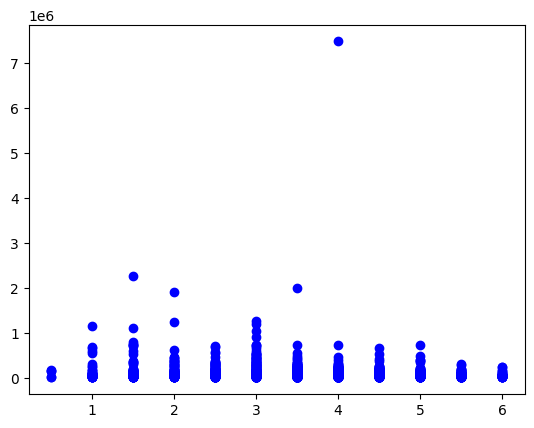

In [56]:
plt.plot(train_feats['score'], train_feats['idle_time-idle'], 'o', color='blue')